# Modelos probabilísticos (Ejercicio)

## Aplicación de Naive Bayes multinomial a la detección de SMS *spam*

En este ejercicio se pide reproducir lo realizado en el caso práctico que se ha descrito en los vídeos (análisis de sentimiento en críticas de cine), pero ahora para detectar cuándo un mensaje corto (SMS) es *spam*.

### El conjunto de datos

El conjunto de datos consiste una serie de mensajes SMS (5574 en total), que están clasificados como mensajes basura (*spam*) o mensajes normales (*ham*). Los datos se pueden obtener en el [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

En concreto, descargar el fichero [smsspamcollection.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip), y descomprimirlo para obtener un fichero de texto SMSSpamCollection. En este fichero de texto hay una línea por cada sms, con el formato: *clase* *tabulador* *sms*. Por ejemplo, la primera línea es:

`ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...`

El fichero debe ser leído convenientemente para poder aplicar la vectorización. Se puede hacer la lectura usando las funciones python de lectura de ficheros, pero se recomienda usar la instrucción `read_table` de la biblioteca `pandas`:

In [82]:
import pandas as pd

*Pandas* es una biblioteca de python muy utilizada para manipular y analizar datos. Si el fichero se lee con la orden `read_table` (se pide averiguar la manera concreta de hacerlo), entonces se obtendrá una tabla (o *Data Frame*), en el que las etiquetas serán una columna y los correspondientes sms otra. Esto permite obtener de manera sencilla la lista de etiquetas o clases, y por otro lado la lista de mensajes, en el mismo orden.  

### Aprendiendo a clasificar SMSs

Se pide reproducir con estos datos lo realizado en el *notebook* en el que se aplica Naive Bayes Multinomial al análisis de sentimientos de críticas de cine, pero ahora para clasificar un SMS como *spam* o como normal. Esto incluye:

* Separación de los textos en entrenamiento y prueba 
* Vectorización de los textos 
* Aprendizaje con `MultinomialNB`
* Mostrar algunas clasificaciones sobre sms concretos.
* Rendimiento sobre entrenamiento y prueba.
* Ajuste manual del parámetro de suavizado
* Vectorización con `min_df` y `stop_words` 

**Nota**: este conjunto de datos no es balanceado (la mayoría son *ham*). Por tanto, usar `score` no es muy ilustrativo del rendimiento, ya que un clasificador "tonto" que siempre predijera *ham* tendría un rendimiento alto. Por ello, en este caso también se hace necesario usar el método `confusion_matrix` del módulo `metrics`. Se pide también explicar la salida que proporciona dicha métrica.

Se pide **comentar adecuadamente cada paso realizado**, relacionándolo con lo visto en la teoría. En particular, se pide mostrar parte de los atributos `class_count_`, `class_log_prior_`, `feature_count_` y `feature_log_prob_`, explicando claramente qué son cada uno de ellos. Explicar también cómo realiza las predicciones el modelo aprendido, tal y como se ha explicado en la teoría.  



## Separación de los textos en entrenamiento y prueba

Importamos los datos del archivo de texo:

In [83]:
import pandas as pd
dataTable = pd.read_table("SMSSpamCollection", names=("type", "text"))
dataTable

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Vamos a crear el método selectData() que divide los datos en train y test según el porcentaje seleccionado. Tendrá 3 parámetros de entrada: 
1. percentage: valor entre 0 y 1 que marca el porcentaje de los datos que serán usados para el entrenamiento. El porcentaje restante de los datos será destinado a pruebas.


2. data: aquí se pasa el dataframe con el total de los datos que serán procesados.


3. shuffleOrder: este valor booleano determina si el orden de los datos se baraja al iniciar el método. Si está a True los datos se desordenarán de forma que nos aseguraremos de que los datos de entrenamiento y pruebas no sean los mismos cada vez que los determinamos.



In [84]:
import math 
from sklearn.utils import shuffle

def selectData(percentage, data, shuffleOrder):
    if(shuffleOrder):
        data = shuffle(data).reset_index(drop=True)
    #Separamos los datos según su tipo.    
    auxSpamData = data.loc[data['type'] == 'spam']
    auxHamData = data.loc[data['type'] == 'ham'] 
    #Sacamos la cantidad de datos de cada tipo.
    count_spam = auxSpamData.shape[0]
    count_ham = auxHamData.shape[0]
    #Y usamos esas cantidades como índices multiplicadas por el porcentaje introducido como atributo.
    indexSpam = math.trunc(count_spam*percentage)
    indexHam = math.trunc(count_ham*percentage)
    trainData = [auxHamData[:indexHam], auxSpamData[:indexSpam]]
    testData = [auxHamData[indexHam:count_ham], auxSpamData[indexSpam:count_spam]]
    #Acabamos retornando una tupla con dos dataframes, el de los datos de entrenamiento y el de los datos de prueba.
    allData = [trainData, testData]
    
    return allData

Usemos el método para separar los textos de entranamiento y prueba. El 80% será de entrenamiento y el 20% de prueba.

In [85]:
completeData = selectData(0.8, dataTable, False)

print('DATOS DE ENTRENAMIENTO:')
print(completeData[0])

print('DATOS DE PRUEBA:')
print(completeData[1])

DATOS DE ENTRENAMIENTO:
[     type                                               text
0     ham  Go until jurong point, crazy.. Available only ...
1     ham                      Ok lar... Joking wif u oni...
3     ham  U dun say so early hor... U c already then say...
4     ham  Nah I don't think he goes to usf, he lives aro...
6     ham  Even my brother is not like to speak with me. ...
...   ...                                                ...
4457  ham  If you want to mapquest it or something look u...
4458  ham  Aight should I just plan to come up later toni...
4459  ham  Die... I accidentally deleted e msg i suppose ...
4461  ham  This is wishing you a great day. Moji told me ...
4462  ham  Thanks again for your reply today. When is ur ...

[3860 rows x 2 columns],       type                                               text
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
8     spam  WINNER!! As a value

## Vectorización de los textos

A continuación vamos a vectorizar los datos. El primer paso será sacar los datos de nuestro dataFrame y crear varias listas en las que separaremos por un lado los textos de los mensajes y por otro sus respectivos tipos de forma ordenada para que la relación entre listas sea directa:

In [86]:
#text_train contendrá los textos de los datos de entrenamiento, incluyendo indiferentemente tipos ham y spam.
text_train = completeData[0][0]['text'].tolist()
text_train.extend(completeData[0][1]['text'].tolist())

#y_train será la lista ordenada de tipos de los mensajes, en nuestro caso aparecerán primero todas las instancias ham y 
# seguidamente todas las instacias spam.
y_train = completeData[0][0]['type'].tolist()
y_train.extend(completeData[0][1]['type'].tolist())

#text_test equivalente a text_train para datos de pruebas.
text_test = completeData[1][0]['text'].tolist()
text_test.extend(completeData[1][1]['text'].tolist())

#y_test equivalente a y_train para datos de pruebas
y_test = completeData[1][0]['type'].tolist()
y_test.extend(completeData[1][1]['type'].tolist())

#Como podemos comprobar tenemos dos listas de entrenamiento de tamaño 4457 (80% de los datos) y dos listas contenedoras
# de la información de prueba con tamaño 1115 (20% de los datos).
print(
"train size: ", len(text_train),
len(y_train),
"test size: ", len(text_test),
len(y_test))

train size:  4457 4457 test size:  1115 1115


Ya hemos obtenido y ordenado los datos en un formato adecuado, a continuación los procesaremos vectorialmente y haremos una serie de comprobaciones. Para ello haremos uso del transformador CountVectorizer:

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

#Le pasamos los textos de entrenamiento con el método fit(), de esta manera se recopila el vocabulario.
vect = CountVectorizer().fit(text_train)

#Con el método transform() conseguiremos el formato de vector en base a los textos.
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<4457x7776 sparse matrix of type '<class 'numpy.int64'>'
	with 59601 stored elements in Compressed Sparse Row format>


Y a continuación podemos ver la representación de esta matriz de vectores:

In [88]:
print("Representación no dispersa de los documentos del ejemplo:\n{}".format(X_train.toarray()))

Representación no dispersa de los documentos del ejemplo:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Analicemos en una primera instancia el vocabulario generado:

In [89]:
feature_names = vect.get_feature_names()
print("Número de términos en el vocabulario: {}".format(len(feature_names)))
print("Primeras 20 características (términos):\n{}".format(feature_names[:20]))
print("Términos del 6990 al 7000:\n{}".format(feature_names[6990:7000]))
print("Términos cada 500 posiciones:\n{}".format(feature_names[::500]))

Número de términos en el vocabulario: 7776
Primeras 20 características (términos):
['00', '000', '000pes', '008704050406', '0089', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06']
Términos del 6990 al 7000:
['tonght', 'tongued', 'tonight', 'tonights', 'tonite', 'tons', 'too', 'took', 'tookplace', 'tool']
Términos cada 500 posiciones:
['00', '4742', 'apology', 'bribe', 'copied', 'earlier', 'french', 'horo', 'kvb', 'milk', 'oranges', 'proverb', 'secretly', 'sterling', 'tooo', 'what']


Como podemos observar el vocabulario contiene 7776 palabras, a primera vista podemos observar que muchas de ellas se refieren al mismo término pero conteniendo algún tipo de falta de ortografía. Esto era de esperar dado el origen de los datos.

## Aprendizaje con MultinomialNB

Vamos a comenzar el entrenamiento mediante el Naive Bayes Multinomial. Como sabemos, el modelo multinomial tiene en cuenta el número de ocurrencias de los términos. Además la ausencia de un término no influye en la clasificación por lo que será un método muy adecuado para el tipo de uso que queremos darle.

In [90]:
from sklearn.naive_bayes import MultinomialNB

# Regresión logística con el parámetro por defecto
multinb=MultinomialNB().fit(X_train,y_train)

Con esa llamada al método fit() y pasando nuestros datos vectorizados de entrenamiento, el modelo NB cuenta el número de instancias de los términos encontrados en cada clase (ham, spam) y guarda esta información en forma de logaritmo de las proporciones en una serie de atributos.

A continuación pasemos a detallar parte de la información sobre algunos de esos atributos en el método:

Con **class_count_** podemos comprobar el número de cada clase. Por supuesto sigue siendo el mismo que marcamos al principio de este documento

In [91]:
print(multinb.class_count_)

[3860.  597.]


Con **class_log_prior_** podemos saber las probabilidades logarítmicas a priori de cada clase del modelo.  

Esto se calcula de la siguiente manera:

&emsp; $$P(Causa|Efecto) = \displaystyle \Bigg[\frac{P(Efecto|Causa)P(Efecto)}{P(Causa))}\Bigg]$$

Siendo:

        1. P(Efecto): La probabilidad que tiene el Efecto de ocurrir.
        2. P(Efecto|Causa): La probabilidad de que el Efecto ocurra dada la Causa como cierta.
        3. P(Causa|Efecto): La probabilidad de que la Causa ocurra dado el Efecto como cierto.
        4. P(Causa): La probabilidad que tiene la Causa de ocurrir.


In [92]:
print(multinb.class_log_prior_)

[-0.14380871 -2.01031406]


Con **feature_count_** se muestra el número de repeticiones de instancias de cada término. Se muestran dos listas, una por cada tipo:

In [93]:
print(multinb.feature_count_)

[[ 0.  0.  1. ...  1.  1.  0.]
 [10. 25.  0. ...  0.  0.  1.]]


Con **feature_log_prob_** tenemos la lista de las probabilidades logarítmicas de las ocurrencias de cada término respecto a todos los demás. Con el contenido de estas listas (una por tipo) se realizarán las predicciones.

In [94]:
print(multinb.feature_log_prob_)

print("Uno por cada palabra del vocabulario y lista: ",multinb.feature_log_prob_.size/2)

[[-10.97594408 -10.97594408 -10.28279689 ... -10.28279689 -10.28279689
  -10.97594408]
 [ -7.59135705  -6.73115578  -9.98925232 ...  -9.98925232  -9.98925232
   -9.29610514]]
Uno por cada palabra del vocabulario y lista:  7776.0


Para explicar de forma teórica cómo realiza el modelo las predicciones debemos tener en cuenta las listas vistas recientemente como una serie de atributos de nuestras instancias que acabarán determinando el valor de clasificación con mayor probabilidad de acierto. 

Tenemos en primer lugar la probabilidad incondicional de pertenecer a una clase, es decir, todos nuestro sms serán necesariamente "ham" o "spam". Esta probabilidad irá ligada a la cantidad de ejemplos de cada tipo en los datos de entrenamiento como observábamos anteriormente.

Por otra parte las probabilidades de aparición de una palabra del vocabulario dado por cierto que se es de una determinada clase serán condicionalmente independientes. Esto lo damos por hecho para contar con que la clase contiene toda la información necesaria acerca de cada atributo y poder simplificar así el problema. De otra manera necesitaríamos una cantidad ingente de datos (instancias de todas las combinaciones). 

Teniendo en cuenta lo anterior podemos saber que las probabilidades del conjunto de atributos dada la clase se pueden factorizar, es decir, tendremos un conjunto de factores (uno por palabra) cuya maximización de producto determinará a qué clase o tipo se predice que pertenece la instancia.

Como conclusión ahora sabemos que, teniendo las listas **feature_log_prob_** (factores de los que hablamos), tendremos un factor posible que añadir al producto según si la palabra aparece o no en la instancia. Si este producto es mayor para el tipo "ham" el mensaje se predice como "ham". De ser mayor el producto "spam" se marcará como "spam". Por supuesto, aunque necesitemos marcar un único tipo categórico siempre podremos analizar la fiabilidad de la predicción hecha según las dos probabilidades calculadas y su aproximación.

## Mostrar algunas clasificaciones sobre sms concretos.

Ya tenemos el modelo en funcionamiento, hagamos alguna comprobaciones para terminar de entenderlo.

En primer lugar saquemos la lista de datos de prueba un par de ejemplo arbitraios con sus respectivos tipos:

In [95]:
print("Segundo SMS del conjunto de test: \n\n{}\n".format(text_test[1]))
print("Clasificación verdadera: {}.\n\n".format(y_test[1]))

print("Milunésimo SMS del conjunto de test: \n\n{}\n".format(text_test[1000]))
print("Clasificación verdadera: {}".format(y_test[1000]))

Segundo SMS del conjunto de test: 

He said i look pretty wif long hair wat. But i thk he's cutting quite short 4 me leh.

Clasificación verdadera: ham.


Milunésimo SMS del conjunto de test: 

URGENT! Your Mobile No 07808726822 was awarded a £2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU

Clasificación verdadera: spam


A simple vista se puede observar la amplia diferencia entre un mensaje tipo "ham" y uno "spam". Veamos qué dice nuestro modelo al preguntar por una predicción para estos mismos mensajes:

In [96]:
print("Predicción del clasificador para el segundo SMS: {}\n".format(multinb.predict(vect.transform([text_test[1]]))[0]))

print("Predicción del clasificador para el milunésimo SMS: {}".format(multinb.predict(vect.transform([text_test[1000]]))[0]))

Predicción del clasificador para el segundo SMS: ham

Predicción del clasificador para el milunésimo SMS: spam


Efectivamente, nuestro modelo ha sido capaz de predecir satisfactoriamente los tipos de estos mensajes. Analicemos con cuánta seguridad se han dado estas predicciones:

In [97]:
print("Predicción de probabilidad para el segundo SMS: {}\n".format(multinb.predict_proba(vect.transform([text_test[1]]))[0]))

print("Predicción de probabilidad para el milunésimo SMS: {}".format(multinb.predict_proba(vect.transform([text_test[1000]]))[0]))

Predicción de probabilidad para el segundo SMS: [1.00000000e+00 5.78325665e-18]

Predicción de probabilidad para el milunésimo SMS: [4.14715943e-20 1.00000000e+00]


Podría decirse que la seguridad es prácticamente completa en los dos casos, tipo "ham" el primero y "spam" el segundo. Si volvemos a los mensajes propiamente dichos puede corroborarse que contienen palabras que alguien esperaría en mensajes de cada tipo, siendo llamativa la cantidad de veces que en los mensajes de "spam" se usan palabras relacionadas a "ganar premios", "llamar de forma urgente" o "enviar algo a una dirección". Vamos a experimentar un poco con este concepto.

Veamos qué ocurre si inventamos un nuevo mensaje y le pedimos al modelo que dé una predicción. Vamos a usar dos palabras que con total seguridad aparecen normalmente en mensajes de tipo spam:

In [98]:
mensaje1 = "win prize"

print("Veces que 'win' aparece en los datos de entrenamiento de tipo 'ham':", multinb.feature_count_[0][feature_names.index("win")])
print("Veces que 'win' aparece en los datos de entrenamiento de tipo 'spam':", multinb.feature_count_[1][feature_names.index("win")])

print("Veces que 'now' aparece en los datos de entrenamiento de tipo 'ham':", multinb.feature_count_[0][feature_names.index("prize")])
print("Veces que 'now' aparece en los datos de entrenamiento de tipo 'spam':", multinb.feature_count_[1][feature_names.index("prize")])

Veces que 'win' aparece en los datos de entrenamiento de tipo 'ham': 9.0
Veces que 'win' aparece en los datos de entrenamiento de tipo 'spam': 53.0
Veces que 'now' aparece en los datos de entrenamiento de tipo 'ham': 0.0
Veces que 'now' aparece en los datos de entrenamiento de tipo 'spam': 76.0


Nuestra suposición era cierta, las palabras "win" y "prize" apenas tienen instancias entre los mensajes de tipo 'ham' usados en el entrenamiento. Y ninguna instancia, de hecho, para la palabra "prize".

Veamos qué predice el modelo:

In [99]:
print("Predicción de mensaje inventado: {}".format(multinb.predict(vect.transform([mensaje1]))[0]))
print("Predicción de probabilidad del mensaje inventado: {}\n".format(multinb.predict_proba(vect.transform([mensaje1]))[0]))  

Predicción de mensaje inventado: spam
Predicción de probabilidad del mensaje inventado: [0.00215656 0.99784344]



La probabilidad de que el mensaje sea 'spam' según el modelo es abrumadora. Esto concuerda perfectamente con la lógica entendida hasta el momento sobre el funcionamiento.

Veamos qué ocurre en un caso más ambiguo:

In [100]:
mensaje2 = "hello urgent"

print("Veces que 'hello' aparece en los datos de entrenamiento de tipo 'ham':", multinb.feature_count_[0][feature_names.index("hello")])
print("Veces que 'hello' aparece en los datos de entrenamiento de tipo 'spam':", multinb.feature_count_[1][feature_names.index("hello")])

print("Veces que 'urgent' aparece en los datos de entrenamiento de tipo 'ham':", multinb.feature_count_[0][feature_names.index("urgent")])
print("Veces que 'urgent' aparece en los datos de entrenamiento de tipo 'spam':", multinb.feature_count_[1][feature_names.index("urgent")])

Veces que 'hello' aparece en los datos de entrenamiento de tipo 'ham': 40.0
Veces que 'hello' aparece en los datos de entrenamiento de tipo 'spam': 4.0
Veces que 'urgent' aparece en los datos de entrenamiento de tipo 'ham': 6.0
Veces que 'urgent' aparece en los datos de entrenamiento de tipo 'spam': 49.0


En esta ocasión la palabra "hello" es claramente predominante en los mensajes 'ham' y la palabra "urgent" lo es en los mensajes 'spam'. Veamos cómo reacciona nuestro modelo:

In [101]:
print("Predicción de mensaje inventado: {}".format(multinb.predict(vect.transform(["hello urgent"]))[0]))
print("Predicción de probabilidad del mensaje inventado: {}".format(multinb.predict_proba(vect.transform(["hello urgent"]))[0]))

Predicción de mensaje inventado: ham
Predicción de probabilidad del mensaje inventado: [0.50778515 0.49221485]


Tal y como era de esperar, la predicción ha sido completamente igualada ganando por algunos puntos la predicción 'ham' y de ahí el tipo predicho. Esto es completamente lógico puesto que a efectos prácticos en nuestro vector existen dos factores contrarios cuyo peso es aproximadamente cercarno para nuestro modelo.

Por supuesto con estos últimos ejemplos no se pretende mostrar un uso correcto o convencional del modelo probabilístico sino más bien comprenderlo más a fondo en base a reproducir instancias extremas poco realistas.

## Rendimiento sobre entrenamiento y prueba.

Vamos a usar la función score() para ver el porcentaje de acierto en las predicciones del modelo.

Realizaremos la medición tanto con los datos de entrenamiento como con los de prueba aunque estos últimos serán los más significativos para medir el éxito de nuestro modelo:

In [102]:
X_test = vect.transform(text_test)

print("Rendimiento de multinb sobre el conjunto de entrenamiento: {:.2f}".format(multinb.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento: 0.99
Rendimiento de multinb sobre el conjunto de test: 0.98


Observamos que el modelo consigue un porcentaje muy alto de acierto, lo cual es bueno pero debemos tener en cuenta una consideración extra. Recordemos que las clases de nuestros datos no están repartidas de manera uniforme, existen muchos más ejemplos de mensaje clasificados como 'ham' que mensajes clasificados como 'spam'.

Es por esto que no debemos preocuparnos únicamente por el porcentaje absoluto de acierto sino que además tendremos que investigar de dónde salen exáctamente los errores que comete el modelo.

Para ello haremos uso de una matrix de confusión:

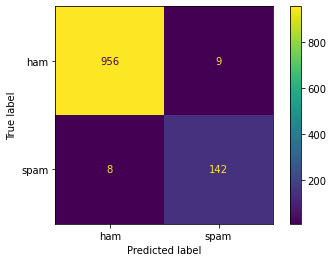

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []

# Montamos una lista de las clases ordenadas de las predicciones hechas por el modelo en base a los datos de prueba.
for i in range(len(y_test)):
    aux = multinb.predict(vect.transform([text_test[i]]))
    y_pred.append(aux) 

# El método recibirá dos listas. La lista de valores correcto (y_test) y la lista de predicciones 
# del modelo respecto a esas instancias (y_pred)
cm = confusion_matrix(y_test, y_pred)

# Por último dibujamos la matriz añadiendo las correspondientes etiquetas.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham","spam"])

disp.plot() 

Según el número de clases de los datos que tratamos de analizar, la matriz de confunsión tendrá una dimensión determinada. En este caso, con dos clases se tienen cuatro posiciones a las que llamaremos [(0,0), (0,1), (1,0), (1,1)].
   1. Posición (0,0): con valor 956, número de ocasiones en que se ha predicho 'ham' y se ha acertado.
   2. Posición (0,1): con valor 9, número de ocasiones en que se ha predicho 'spam' y se ha fallado.
   3. Posición (1,0): con valor 8, número de ocasiones en que se ha predicho 'ham' y se ha fallado.
   4. Posición (1,1): con valor 142, número de ocasiones en que se ha predicho 'spam' y se ha acertado.
   
Ahora poseemos más información para analizar el comportamiento del modelo. Podemos observar que los errores (posiciones (0,1) y (1,0)) no se concentran especialmente en una de las posiciones. Si por ejemplo todos los errores se concentrasen en (0,1) y en gran cantidad, sería evidente que el modelo acierta principalmente por predecir casi siempre 'ham' y la cantidad mayoritaria de aciertos llegaría por haber un mayor número de casos 'ham' entre el groso de datos y no por tener un modelo eficaz.  

También puede destacarse que aunque haya una cantidad parecida de errores de predicción de cada tipo, no deben tenerse en consideración de la misma manera, es decir, no tendrá la misma importancia un error por predicción de 'ham' para el que poseemos muchas más instancias concretas que un error por predicción de 'spam', del que disponíamos en menor cantidad durante el entrenamiento.

## Ajuste manual del parámetro de suavizado

El suavizado de las estimaciones es un tratamiento que se realiza a los datos con objetivo de solventar el problema que surje cuando no tenemos instancias de algún tipo y la predicción hacia un lado alcanza valores de 0 o extremádamente bajos. El método MultinomialNB() nos permite hacer uso de un parámetro 'alpha', el parámetro de suavizado. Este parámetro es 1.0 por defecto pero al modificarlo podremos observar cambios en el rendimiento del modelo y nos posibilitará evitar el sobreajuste en las predicciones.

Como aprendimos en teoría, el parámetro de suavizado es fundamentalmente una constante que se suma en los diversos cálculos de probabilidades del modelo. Será necesario calibrar a mano el valor más adecuado para este parámetro.

Empecemos dándole un valor alpha=10:

In [104]:
multinb_alpha=MultinomialNB(alpha=10).fit(X_train,y_train)
print("Rendimiento de multinb sobre el conjunto de entrenamiento {:.2f}".format(multinb_alpha.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb_alpha.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento 0.96
Rendimiento de multinb sobre el conjunto de test: 0.96


Podemos observar que el rendimiento es menor. Para seleccionar el mejor valor de suavizado podemos hacer uso del mnétodo GridSearchCV(). Se trata de un modelo predictivo en sí que nos devolverá el mejor entre varios valores posibles de alpha.

In [105]:
from sklearn.model_selection import GridSearchCV
param_grid_nb = {'alpha': [0.0001,0.001, 0.01,0.1, 1, 10,100,200]} # Posibles valores
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train, y_train) # Entrenamiento
print("Mejor parámetro: ", grid_nb.best_params_)
print("Rendimiento de MultonomialNB en validación cruzada, con el mejor parámetro: {:.2f}".format(grid_nb.best_score_))

Mejor parámetro:  {'alpha': 0.01}
Rendimiento de MultonomialNB en validación cruzada, con el mejor parámetro: 0.98


Parece que el mejor valor encontrado para alpha es 0.01 y como observamos a continuación, tener un parámetro de suavizado bajo no va en detrimento de la efectividad del modelo. Necesita poco suavizado.

In [106]:
print("Rendimiento sobre prueba (del mejor parámetro en validación cruzada): {:.2f}".format(grid_nb.score(X_test, y_test)))

Rendimiento sobre prueba (del mejor parámetro en validación cruzada): 0.98


## Vectorización con min_df y stop_words

Una idea impoortante a tener en cuenta en este tipo de modelos es que no necesariamente todas las palabras de nuestro vocabulario son relevantes para las predicciones. Esto es debido a que existen palabras de uso tan común y además con un significado tan neutro que no nos ayudarán a determinar el tipo de un mensaje. Algunos ejemplos de este tipo de palabras serían 'que', 'de', 'of' o 'the'. Por supuesto según el idioma tendremos palabras distintas, denominadas "stop words".

Por otra parte también será interesante descartar palabras cuya cantidad de apariciones en los datos sea relativamente baja. Para esto usaremos "min_df" que marca el rango de cantidad de instancias a partir del cual se seguirá teniendo en cuenta el elemento. Se debe escoger un "min_df" adecuado en función a la cantidad de instancias totales de nuestros datos.

Algo importante a este respecto es que el objetivo de volver a vectorizar nuestros datos será una cuestión de eficiencia puesto que estaremos eliminando una gran cantidad de información redundante (mayor eficiencia) pero no estamos añadiendo ninguna nueva (igual desempeño).

Vamos a usar el método CountVectorizer(), al que indicaremos un valor min_df=10 y stop_words="english" para que tenga en cuenta las palabras más cotidianas del habla inglesa.

In [107]:
vect2 = CountVectorizer(min_df=10, stop_words="english").fit(text_train)
X2_train = vect2.transform(text_train)

In [108]:
print("Número de términos en el vocabulario original: {}".format(len(feature_names)))
feature_names2 = vect2.get_feature_names()
print("Número de términos en el vocabulario con stop words y min_df: {}".format(len(feature_names2)))
feature_names2

Número de términos en el vocabulario original: 7776
Número de términos en el vocabulario con stop words y min_df: 693


['00',
 '000',
 '03',
 '0800',
 '08000839402',
 '08000930705',
 '10',
 '100',
 '1000',
 '10p',
 '11',
 '12hrs',
 '150',
 '150p',
 '150ppm',
 '16',
 '18',
 '1st',
 '20',
 '200',
 '2000',
 '250',
 '2lands',
 '2nd',
 '50',
 '500',
 '5000',
 '750',
 '800',
 '8007',
 '86688',
 '87066',
 'abiola',
 'able',
 'abt',
 'account',
 'actually',
 'address',
 'aft',
 'afternoon',
 'age',
 'ago',
 'ah',
 'aight',
 'alright',
 'amp',
 'angry',
 'ans',
 'answer',
 'anytime',
 'apply',
 'ard',
 'area',
 'ask',
 'askd',
 'asked',
 'asking',
 'ass',
 'attempt',
 'available',
 'await',
 'award',
 'awarded',
 'away',
 'awesome',
 'b4',
 'babe',
 'baby',
 'bad',
 'balance',
 'bank',
 'bcoz',
 'beautiful',
 'bed',
 'believe',
 'best',
 'better',
 'big',
 'birthday',
 'bit',
 'blue',
 'bonus',
 'book',
 'bored',
 'bout',
 'box',
 'boy',
 'boytoy',
 'break',
 'bring',
 'brother',
 'bslvyl',
 'bt',
 'bus',
 'busy',
 'buy',
 'call2optout',
 'called',
 'caller',
 'calling',
 'calls',
 'camcorder',
 'came',
 'camer

Nuestro vocabulario se ha reducido de 7776 palabras a 693 siendo ahora más de diez veces menor. Esto puede marcar una gran diferencia en eficiencia para modelos que manejan cantidades masivas de datos.

Analicemos con este nuevo vocabulario si cambian en algo las características del modelo:

In [109]:
multinb2=MultinomialNB(alpha=0.1).fit(X2_train,y_train)

In [110]:
X2_test = vect2.transform(text_test)

print("Rendimiento de multinb2 sobre el conjunto de entrenamiento {:.2f}".format(multinb2.score(X2_train,y_train)))
print("Rendimiento de multinb2 sobre el conjunto de test: {:.2f}".format(multinb2.score(X2_test,y_test)))

Rendimiento de multinb2 sobre el conjunto de entrenamiento 0.98
Rendimiento de multinb2 sobre el conjunto de test: 0.98


Como podemnos observar, la capacidad de predicción del modelo sigue intacta, ahora de forma mucho más optimizada.

Podemos ahora, si lo deseamos, volver a calcular el parámetro de suavizado más optimo para el modelo.

In [111]:
grid2_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid2_nb.fit(X2_train, y_train)
print("Mejor parámetro: ", grid2_nb.best_params_)
print("Rendimiento de MultonomialNB (con min_df y stop words) en validación cruzada, con el mejor parámetro: {:.2f}".format(grid2_nb.best_score_))
print("Rendimiento sobre prueba (del mejor parámetro en validación cruzada): {:.2f}".format(grid2_nb.score(X2_test, y_test)))

Mejor parámetro:  {'alpha': 10}
Rendimiento de MultonomialNB (con min_df y stop words) en validación cruzada, con el mejor parámetro: 0.98
Rendimiento sobre prueba (del mejor parámetro en validación cruzada): 0.98


El parámetro de suavizado más adecuado en esta ocasión es alpha=10. Para que ahora nuestro modelo es algo más sensible al sobreajuste y de ahí que el valor del parámetro haya aumentado.